# BBB implementation of the Anisotropic Quadratic Porous Medium Equation using taichi

$\newcommand\diver{\mathrm{div}}\DeclareMathOperator\prox{prox}\DeclareMathOperator\argmin{argmin}$

**Problem formulation.** The PDE of interest reads
\begin{align*}
    \partial_t u &= \frac 1 2 \diver(D \nabla u^2) + f,&
    u(0) &= u_0.
\end{align*}
Following the BBB principle, we consider the optimization problem
\begin{align*}
    \inf_{\phi(T)=0} \int \frac{(\partial_t \phi)^2}{1-\diver(D \nabla \phi)} + F \phi,
\end{align*}
where $F(t,x) = -u_0(x)+\int_0^t f(s,x) ds$.

**Discretization.**
Focusing first on the case $D=I$ the identity matrix, and $d=1$.

## 0. Importing the required libraries

In [1]:
# mps : M1, cuda : nvidia graphics, cpu : all platforms
#device = 'mps'; agd_path = "../../../GithubM1/AdaptiveGridDiscretizations" 
device = 'cuda'; agd_path = "../../../GithubDell/AdaptiveGridDiscretizations" 

import sys; sys.path.insert(0,agd_path)
from agd import AutomaticDifferentiation as ad
from agd import LinearParallel as lp
from agd import FiniteDifferences as fd
from scipy.sparse.linalg import lsqr as sparse_lsqr
norm = ad.Optimization.norm
norminf = ad.Optimization.norm_infinity
from agd.Plotting import savefig

In [2]:
from BBB import Proj,QPME,Prox,Misc
from BBB.Misc import convert_dtype,tifunc

[Taichi] version 1.7.2, llvm 15.0.1, commit 0131dce9, win, python 3.11.11


In [3]:
import taichi as ti
#import torch
import numpy as np
from matplotlib import pyplot as plt
import copy

cmul = ti.math.cmul; cconj = ti.math.cconj
np.set_printoptions(linewidth=2000)

## 0.1 Additional configuration

The following cell is required for the GPU implementation.

In [4]:
import torch 
torch.asarray(np.ones(2).astype(np.float32),device=device)

ti.init(arch=ti.gpu,default_fp=ti.f32) # Default data types are f32 et i32
ρ = np.random.rand(6,7).astype(np.float32)
ρ_mps = torch.asarray(ρ,device=device)
proj_even = Proj.mk_proj_even()
proj_even(ρ_mps)
proj_odd = Proj.mk_proj_odd()
proj_odd(ρ_mps)

m = np.random.rand(6,7).astype(np.float32)
m_mps = torch.asarray(m,device=device)

dt=1.; dx=1.; 
proj_Iso = QPME.mk_proj_Iso(dt,dx,ρ_mps)
proj_odd(m_mps); proj_even(ρ_mps)
torch.fft.fftn(m_mps)

proj_Iso(m_mps,ρ_mps)

[Taichi] Starting on arch=cuda


(tensor([[-0.1844, -0.0839, -0.0573, -0.1085,  0.0176,  0.1592,  0.0603],
         [-0.0194,  0.0127,  0.0706,  0.1712,  0.1091, -0.1125, -0.1878],
         [ 0.0157, -0.0669,  0.1796,  0.1818,  0.0142,  0.1461,  0.1300],
         [-0.0157,  0.0669, -0.1796, -0.1818, -0.0142, -0.1461, -0.1300],
         [ 0.0194, -0.0127, -0.0706, -0.1712, -0.1091,  0.1125,  0.1878],
         [ 0.1844,  0.0839,  0.0573,  0.1085, -0.0176, -0.1592, -0.0603]],
        device='cuda:0'),
 tensor([[ 0.2249,  0.0061, -0.0843,  0.0382, -0.0169, -0.1520, -0.0161],
         [-0.1204,  0.0800, -0.0064, -0.1392, -0.0324,  0.0885,  0.1298],
         [ 0.0158,  0.0543, -0.0491,  0.0235,  0.1270, -0.0577, -0.1139],
         [-0.0158, -0.2748,  0.1952,  0.1933, -0.1725,  0.0903, -0.0157],
         [ 0.0158,  0.0543, -0.0491,  0.0235,  0.1270, -0.0577, -0.1139],
         [-0.1204,  0.0800, -0.0064, -0.1392, -0.0324,  0.0885,  0.1298]],
        device='cuda:0'))

However, we use CPU for most of the notebook (consistency, basic tests).

In [7]:
# CPU
ti.init(arch=ti.cpu,default_fp=ti.f64) # Default data types are f32 et i32
# Note : could not reach double precision when default_fp=f32, even with numerous type annotations. 
# There must be some hidden intermediate variables with f32 type. 
#from scipy.fft import fft2,ifft2,fftn,ifftn # Scipy accepts both float32 and float64

[Taichi] Starting on arch=x64


## 1. Orthogonal projection

Taichi function require typed arguments. Since the code is meant to be executed on both CPUs and GPUs, it is a bit annoying to fix the floating point precision a priori. In addition, when checking (second order) convergence rates, it is preferable to perform float64 computations.

There are two ways to handle this:
- use factory methods where the float type is a parameter. 
    - $+$ Can pass additional parameters, such as dimensionality, number of iterations, stopping criteria.
    - $+$ Can do some pre-processing.
    - $-$ A bit cumbersome.
- use the 'float' annotation, which means 'default float' for Taichi. 
    - $-$ 'float' means something else for cupy, numpy
    - $-$ we rely on the fact that Python ignores these annotations, which could be subject to change


### 1.1 Isotropic Laplacian

Let us check this projection, by comparing with a lsqr implementation.

<!---
# Odd projections, slightly different implems. Not sure wether taichi allows compiler optimizations to discard intermediate variables. So I keep them for eventual performance test.

def mk_proj_odd(float_t=ti.f32): # We will likely need a higher dimensional counterpart
    @ti.kernel
    def proj_odd(m:ti.types.ndarray(dtype=float_t,ndim=2)):
        """In place projection of the momentum onto odd functions: 
        [a0,..,a_{Nt-1},-a_{Nt-1},...,-a_0]"""
        Nt = m.shape[0]//2
        Nx = m.shape[1]
        for t,x in ti.ndrange(Nt,Nx):
            rt = 2*Nt-1-t
            m_avg:float_t = (m[t,x]+m[rt,x])/2
            m[t, x] -= m_avg
            m[rt,x] -= m_avg
    return proj_odd

def mk_proj_odd2(float_t=ti.f32): # We will likely need a higher dimensional counterpart
    @ti.kernel
    def proj_odd(m:ti.types.ndarray(dtype=float_t,ndim=3)):
        """In place projection of the momentum onto odd functions: 
        [a0,..,a_{Nt-1},-a_{Nt-1},...,-a_0]"""
        Nt = m.shape[0]//2
        Nx = m.shape[1:]
        for tx in ti.grouped(ti.ndrange(Nt,*Nx)):
            t = tx[0]
            rtx = tx # Vector is copied
            rtx[0] = 2*Nt-1-t
            m_avg:float_t = (m[tx]+m[rtx])/2
            m[tx] -= m_avg
            m[rtx] -= m_avg
    return proj_odd


def mk_proj_even(float_t=ti.f32):
    @ti.kernel
    def proj_even(ρ:ti.types.ndarray(dtype=float_t,ndim=2)):
        """In place projection of the density onto even functions:
        [a, a1,...,a_{Nt-1}, b, a_{Nt-1},...,a1]"""
        Nt = ρ.shape[0]//2
        Nx = ρ.shape[1]
        for t,x in ti.ndrange((1,Nt),Nx):
            rt = 2*Nt-t
            ρ_avg:float_t = (ρ[t,x]+ρ[rt,x])/2
            ρ[t, x] = ρ_avg
            ρ[rt,x] = ρ_avg
    return proj_even


def mk_proj_continuity_Dt_Dxx(dt,dx,ρ):
    """Factory of projection onto continuity equation Dt ρ + Dxx m = 0
    - dt,dx : timestep and gridscale
    - ρ : used for dtype and shape
    """
    # Data types and conversions
    np_float_t = ρ.dtype.type
    float_t = dtypeConversions['ti'][np_float_t]
    shape = ρ.shape
    vec2 = ti.lang.matrix.VectorType(2,float_t)
    π = np_float_t(np.pi) 
    
    # Make helper functions
    def vec2_from_cplx(arr): return arr.view(np_float_t).reshape(arr.shape+(2,))
    proj_even = mk_proj_even(float_t); proj_odd = mk_proj_odd(float_t) 

    # Compute the Fourier transform of differential operators
    ξt = np.arange(shape[0],dtype=np_float_t)/shape[0]
    ξx = np.arange(shape[1],dtype=np_float_t)/shape[1]
    FDt = (np.exp(2j*π*ξt)-1)/dt # Applied to ρ, which is shifted left w.r.t m
    FDxx = 2*(np.cos(2*π*ξx)-1)/dx**2
                                             
    @ti.kernel 
    def proj_fourier_Dt_Dxx(
        Fm:ti.types.ndarray(dtype=vec2,ndim=2),
        Fρ:ti.types.ndarray(dtype=vec2,ndim=2),
        FDt:ti.types.ndarray(dtype=vec2,ndim=1),
        FDxx:ti.types.ndarray(dtype=float_t,ndim=1)):
        for t,x in Fm: # In the Fourier domain
            vv:float_t = FDt[t][0]**2 + FDt[t][1]**2 + FDxx[x]**2
            if vv>0:
                xv:float_t = ti.math.cmul(FDt[t],Fρ[t,x])+FDxx[x]*Fm[t,x] # Zero if continuity eq satisfied
                Fm[t,x] -= FDxx[x]*xv/vv
                Fρ[t,x] -= ti.math.cmul(ti.math.cconj(FDt[t]),xv)/vv
    
    def proj_continuity_Dt_Dxx(m,ρ):
        """In place projection onto the continuity equation Dt ρ + Dxx m = 0"""
        proj_odd(m); proj_even(ρ)  # Project m onto odd functions, and ρ onto even functions
        Fm = fft2(m); Fρ = fft2(ρ)
        proj_fourier_Dt_Dxx(vec2_from_cplx(Fm),vec2_from_cplx(Fρ),vec2_from_cplx(FDt),FDxx) # Pointwise projection
        m[:] = ifft2(Fm).real; ρ[:] = ifft2(Fρ).real # Inverse time-space fft
        return m,ρ
        
    return proj_continuity_Dt_Dxx
--->

In [8]:
def QPME_cstr_Iso(m,ρ,dt,dx):
    """The residues of the linear constraints Dtρ + Δm = 0 and  m(t) = -m(2T-t)"""
    e = np.eye(ρ.ndim).astype(int)
    et = e[:,0]; ex = e[:,1:] # Time axis is the first one, space axes are the other ones
    Dtρ = fd.DiffUpwind(ρ,et,dt,padding=None) # Now using *periodic* time boundary conditions
    Dxxm = fd.Diff2(m,ex,dx,padding=None) # Periodic space boundary conditions
    Δm = Dxxm.sum(axis=0)
    nT = len(m)//2
    return dt*(Dtρ+Δm), m[:nT]+m[nT:][::-1] # dt introduced for normalization

In [9]:
dt=0.7; dx=0.6; shape = (6,7)
np.random.seed(42)
m,ρ = [np.random.rand(*shape)-0.5 for i in range(2)]

proj_ti = QPME.mk_proj_Iso(dt,dx,ρ)
proj_lsqr = Proj.make_lsqr_proj(QPME_cstr_Iso,(m,ρ),Aargs=(dt,dx))
m_ti,ρ_ti = proj_ti(m.copy(),ρ.copy())
m_lsqr,ρ_lsqr = proj_lsqr(m,ρ)

cstr_cont,cstr_sym = QPME_cstr_Iso(m_ti,ρ_ti,dt,dx)
print(f"After fft projection. Continuity equation : {norminf(cstr_cont)}, Symmetry {norminf(cstr_sym)}")
cstr_cont,cstr_sym = QPME_cstr_Iso(m_lsqr,ρ_lsqr,dt,dx)
print(f"After lsqr projection. Continuity equation : {norminf(cstr_cont)}, Symmetry {norminf(cstr_sym)}")
print(f"{norminf(m_ti-m_lsqr)=}, {norminf(ρ_ti-ρ_lsqr)=}")
assert np.allclose(m_ti,m_lsqr,atol=1e-5)
assert np.allclose(ρ_ti,ρ_lsqr,atol=1e-5)

After fft projection. Continuity equation : 2.3314683517128283e-16, Symmetry 5.551115123125783e-17
After lsqr projection. Continuity equation : 1.5425350110795375e-05, Symmetry 1.773193232468273e-06
norminf(m_ti-m_lsqr)=2.3514599064994313e-06, norminf(ρ_ti-ρ_lsqr)=6.665699750357801e-07


### 1.2 Anisotropic Laplacian

**Modified code, tests do not pass anymore, see tiPorousAniso notebook**

We consider the orthogonal projections onto the sets of constraints:
$$
    \partial_\tau \rho + \sum_{e \in E} \partial_h^{+e} m^e = 0,
$$
and
$$
    m^e = \lambda^e \mu^e, \ \forall e \in E,
$$
and
$$
    -\partial_h^{-e} m = \mu^e, \ \forall e \in E.
$$
The first and last projections are computed in the Fourier domain, and the middle one in usual coordinates.

Let us control these projections, by comparing with an lsqr implementation.

In [10]:
def QPME_cstr_λ(m,μ,λ): return m-λ*μ
def QPME_cstr_E0(me,ρ,E,dt,dx):
    nT=len(me)//2
    et = np.zeros(ρ.ndim,dtype=int); et[0]=1
    return me[:nT]+me[nT:][::-1], fd.DiffUpwind(ρ,et,dt,padding=None) \
    + sum([fd.DiffUpwind(me[...,i],(0,*e),dx,padding=None) for i,e in enumerate(E)])
def QPME_cstr_E1(μe,m,E,dt,dx):
    nT=len(μe)//2
    return μe[:nT]+μe[nT:][::-1],*[μe[...,i] - fd.DiffUpwind(m,(0,*e),-dx,padding=None) for i,e in enumerate(E)]

In [11]:
dt=0.7; dx=0.6; shape = (6,7)
np.random.seed(42)
m,μ = [np.random.rand(*shape)-0.5 for i in range(2)]
λ = np.random.rand(*shape[1:])

proj_ti = QPME.mk_proj_λ(λ)
proj_lsqr = Proj.make_lsqr_proj(QPME_cstr_λ,(m,μ),Aargs=(λ,))
m_ti,μ_ti = proj_ti(m.copy(),ρ.copy())
m_lsqr,μ_lsqr = proj_lsqr(m,ρ)
assert np.allclose(m_ti,m_lsqr,atol=1e-6)
assert np.allclose(μ_ti,μ_lsqr)

In [12]:
dt=0.7; dx=0.6; shape = (6,7)
E = [[1],[-2]] # One dimensional
np.random.seed(42)
m,ρ = [np.random.rand(*shape)-0.5 for i in range(2)]
me,μe = [np.random.rand(*shape,len(E))-0.5 for i in range(2)]

proj_ti = QPME.mk_proj_E(dt,dx,E,ρ)
proj_lsqr0 = Proj.make_lsqr_proj(QPME_cstr_E0,(me,ρ),Aargs=(E,dt,dx))
proj_lsqr1 = Proj.make_lsqr_proj(QPME_cstr_E1,(μe,m),Aargs=(E,dt,dx))

m_ti,ρ_ti,me_ti,μe_ti = proj_ti(m,ρ,me,μe)
me_lsqr,ρ_lsqr = proj_lsqr0(me,ρ)
μe_lsqr,m_lsqr = proj_lsqr1(μe,m)

print(f"{[norminf(x) for x in QPME_cstr_E0(me_lsqr,ρ_lsqr,E,dt,dx)]}, {[norminf(x) for x in QPME_cstr_E1(μe_lsqr,m_lsqr,E,dt,dx)]}")
print(f"{[norminf(x) for x in QPME_cstr_E0(me_ti,ρ_ti,E,dt,dx)]}, {[norminf(x) for x in QPME_cstr_E1(μe_ti,m_ti,E,dt,dx)]}")
for x_lsqr,x_ti in zip((m_lsqr,ρ_lsqr,me_lsqr,μe_lsqr), (m_ti,ρ_ti,me_ti,μe_ti)):
    assert np.allclose(x_lsqr,x_ti)

[2.7755575615628914e-17, 2.220446049250313e-16], [6.938893903907228e-17, 1.3877787807814457e-16, 8.326672684688674e-17]
[1.1102230246251565e-16, 3.885780586188048e-16], [8.326672684688674e-17, 0.2753098149227198, 0.29721833116611124]


AssertionError: 

In [ ]:
dt=0.7; dx=0.6; shape = (6,7,8)
E = [[1,0],[1,1],[0,1],[-1,1]] # Two dimensional
np.random.seed(42)
m,ρ = [np.random.rand(*shape)-0.5 for i in range(2)]
me,μe = [np.random.rand(*shape,len(E))-0.5 for i in range(2)]

proj_ti = QPME.mk_proj_E(dt,dx,E,ρ)
proj_lsqr0 = Proj.make_lsqr_proj(QPME_cstr_E0,(me,ρ),Aargs=(E,dt,dx))
proj_lsqr1 = Proj.make_lsqr_proj(QPME_cstr_E1,(μe,m),Aargs=(E,dt,dx))

m_ti,ρ_ti,me_ti,μe_ti = proj_ti(m,ρ,me,μe)
me_lsqr,ρ_lsqr = proj_lsqr0(me,ρ)
μe_lsqr,m_lsqr = proj_lsqr1(μe,m)

for x_lsqr,x_ti in zip((m_lsqr,ρ_lsqr,me_lsqr,μe_lsqr), (m_ti,ρ_ti,me_ti,μe_ti)):
    assert np.allclose(x_lsqr,x_ti)

## 2. Proximal operator

The QPME energy is 
$$
    \int \frac{m^2} {2 \rho} - sign(t) m F + \chi(\rho(T,x)=1)
$$
where $F(t,x) := u_0(x) - \int_0^t f(s,x) ds$, so as to implement a r.h.s. $f$ and initial condition $u_0$.
Finally, one needs to take into account the sign change of $m$.

We "validate" by comparing with an already tested numpy implementation.

In [14]:
def prox_perspective_np(τ,x,niter=12,verb=1,cupy_kernel=True):
    η = x[0]; y = x[1:]
    Ny=np.linalg.norm(y,axis=0)
    to_origin = τ*η+Ny**2/2<=0 # Wether prox is attained at the origin
    s = np.maximum( (2*Ny/τ)**(1/3), np.maximum(0,-2*(η+τ)/τ)**(1/2) ) # Over estimate the root
    for i in range(niter): # Fixed number of Newton iterations, without damping
        s -= (τ*s**3 + 2*(η+τ)*s - 2*Ny)/(3*τ*s**2+2*(η+τ)) 
    sol = np.concatenate(((η+τ*s**2/2)[None],np.where(Ny==0,0,1-τ*s/Ny)*y),axis=0)
    residue = np.where(to_origin,0,τ*s**3 + 2*(η+τ)*s - 2*Ny)
    if verb>=0 and norminf(residue)>1e-4:
        print("Should be zero if Newton perspective converged :",norminf(residue),"at",np.argmax(np.abs(residue))) 
    return np.where(to_origin,np.zeros_like(x),sol)

def prox_obj(τ,ρ0,m0,u0):
    """Proximal operator of the objective function m^2/(2ρ)-u0 m, with constraint ρ(T)=1."""
    nT = len(ρ0)//2
    ϵ = np.zeros_like(u0,shape=(2*nT,*(1,)*(ρ0.ndim-1)))
    ϵ[:nT] = 1; ϵ[nT:] = -1 # Signs corresponding to the anti-symmetric extension of m
    x0 = np.asarray([ρ0,m0+τ*ϵ*u0]) 
    x = prox_perspective_np(τ,x0)
    ρ = x[0]; m = x[1]
    ρ[nT] = 1 # Enforce the constraint, and use explicit prox for the quadratic objective
    m[nT] = (m0[nT]-τ*u0)/(1+τ) # Caution : anti-symmetric extension of m
    return ρ,m

In [15]:
shape=(6,7); τ=1
np.random.seed(42)
m,ρ = [np.random.rand(*shape)-0.5 for i in range(2)]
u0 = np.random.rand(shape[1])
f=np.zeros_like(m,shape=(shape[0]//2+1,shape[1]))

prox_ti = QPME.mk_prox_Iso(dt,dx,Prox.mk_rhs(dt,u0,f))
m_ti,ρ_ti = prox_ti(m.copy(),ρ.copy(),τ)
ρ_np,m_np = prox_obj(τ,ρ,m,u0)

assert np.allclose(m_ti,m_np)
assert np.allclose(ρ_ti,ρ_np)

## 3. Tests, one dimensional

- CPU and GPU
- Barenblatt and synthetic solution with non-constant coefficient
- Validate second order

### 3.1 CPU

In [16]:
#mCP,ρCP = run_CP(u0_mps,dx,dt,nT,τ_f=1,maxiter=200)

In [5]:
def run_CP(u0,dx,dt,nT,τ_f=1,verb=0,maxiter=1000,rhs=None):
    # Normalization of the initial condition
    xp = Misc.get_array_module(u0)
    if xp is not np: u0_xp=u0; u0=u0.cpu().numpy() # Only for some cheap preprocessing...
    np_float_t = Misc.convert_dtype['np'][u0.dtype]
    Nu0 = np.sqrt(np.sum(u0**2)/np_float_t(u0.size)) # Averaged L2 norm of u0
    u0 = u0/Nu0
    dt = dt*Nu0
    
    # Initialization
    ρ = np.ones_like(u0,shape=(2*nT,*u0.shape))
    m = np.asarray([*(u0,)*nT,*(-u0,)*nT])
    if rhs is None: rhs = np.zeros_like(ρ[:nT+1])
    Rhs = Prox.mk_rhs(dt,u0,rhs)
    if xp is not np: ρ,m,Rhs = [Misc.asarray(e,like=u0_xp) for e in (ρ,m,Rhs)]
    
    x = Misc.asobjarray(m,ρ) # x contains the pair of variables ρ,m
    y = 0*x # Dual variable
    tx = copy.deepcopy(x)
    dt,dx,τ_f = map(np_float_t,(dt,dx,τ_f))
    
    # Note : prox_f,proj_g, are inplace operators by default (modifiy input)
    prox_f = Misc.useobjarray(QPME.mk_prox_Iso(dt,dx,Rhs))
    proj_g = Misc.useobjarray(QPME.mk_proj_Iso(dt,dx,ρ)) # projection operator
    def prox_gs(y,τ=1): return y-proj_g(y,inplace=False) # Projection onto orthogonal space
    τ_gs = 1/τ_f # One needs τ_f τ_gs |K|^2 <1, but the coupling operator is the identity

    for i in range(maxiter): # Primal-dual optimization loop
        y = prox_gs(y+τ_gs*tx,τ_gs)
        xold=x
        x = prox_f(x-τ_f*y,τ_f)
        tx = 2*x-xold
    return x[0]*Nu0,x[1] # Put back the normalization

In [18]:
nX = 1024; nT = 20
#nX = 100; nT = 10
#nX = 5; nT=2
aX,dx = np.linspace(0,1,nX,retstep=True,endpoint=False)
aX+=dx/2
X = aX[None]

Ti = 1e-4; Tf = 1e-3; T = Tf-Ti; u0 = QPME.Barenblatt(Ti,X-0.5)
dt = T/nT

In [19]:
%%time
mCP,ρCP = run_CP(u0,dx,dt,nT,τ_f=1,maxiter=200)
#uCP = QPME.u_from_mρ(mCP,ρCP)

CPU times: total: 859 ms
Wall time: 1.18 s


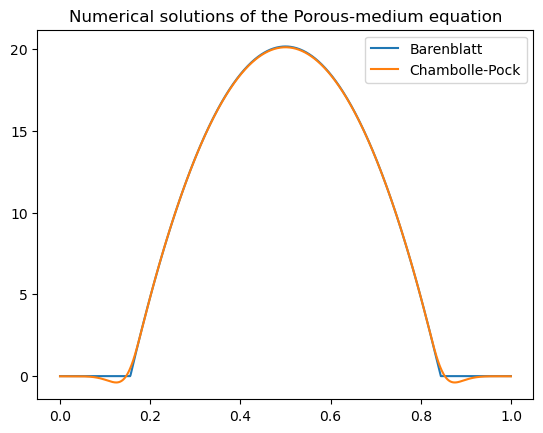

In [20]:
uCP = QPME.u_from_mρ(mCP,ρCP)
iT = nT-1 # Choose from 0 (initial condition) to  nT-1 (final time)
t = Ti+dt*(iT+0.5)
plt.title("Numerical solutions of the Porous-medium equation")
#plt.plot(aX,uN[iT],label="Newton")
plt.plot(aX,QPME.Barenblatt(Ti+dt*(iT+0.5), X-0.5),label="Barenblatt")
plt.plot(aX,uCP[iT],label="Chambolle-Pock")
plt.legend();

### 3.2 CPU, float32

Everything works, but the improvement in speed is modest (approx 25% it appears).

In [21]:
ti.init(arch=ti.cpu,default_fp=ti.f32)

[Taichi] Starting on arch=x64


In [22]:
nX = 2**15; nT = 16
#nX = 1024; nT = 20
#nX = 100; nT = 10
#nX = 5; nT=2
aX,dx = np.linspace(0,1,nX,retstep=True,endpoint=False)
aX+=dx/2
X = aX[None]

Ti = 1e-4; Tf = 1e-3; T = Tf-Ti; u0 = QPME.Barenblatt(Ti,X-0.5)
dt = T/nT

In [23]:
%%time
mCP,ρCP = run_CP(u0.astype(np.float32),dx,dt,nT,τ_f=1,maxiter=200)
#uCP = QPME.u_from_mρ(mCP,ρCP)

CPU times: total: 21.1 s
Wall time: 25.1 s


### 3.3 GPU

For relatively small test cases, the M1 GPU is in fact slower than the CPU. 
Even for large test cases, the improvement is not great on the M1.

In [24]:
nX = 2**15; nT = 16
#nX = 100; nT = 10
#nX = 5; nT=2
aX,dx = np.linspace(0,1,nX,retstep=True,endpoint=False)
aX+=dx/2
X = aX[None]

Ti = 1e-4; Tf = 1e-3; T = Tf-Ti; u0 = QPME.Barenblatt(Ti,X-0.5)
dt = T/nT

In [25]:
ti.init(arch=ti.gpu,default_fp=ti.f32)

[Taichi] Starting on arch=cuda


In [26]:
u0_gpu = torch.asarray(u0.astype(np.float32),device=device)

In [27]:
%%time
mCP,ρCP = run_CP(u0_gpu,dx,dt,nT,τ_f=1,maxiter=200)

CPU times: total: 656 ms
Wall time: 1.14 s


In [28]:
2**17

131072

## 4. Two dimensional tests

### 4.1 Isotropic

In [5]:
ti.init(arch=ti.cpu,default_fp=ti.f64)

[Taichi] Starting on arch=x64


In [6]:
nX = 35; nT = 6
#nX = 50; nT = 10 # bit longish
aX,dx = np.linspace(0,1,nX,retstep=True,endpoint=False)
aX+=dx/2
X = np.array(np.meshgrid(aX,aX,indexing='ij'))

Ti = 2e-5
u0 = QPME.Barenblatt(Ti,X-0.5)
Tf = 2e-4; T = Tf-Ti
dt = T/nT
Δϕpos = 0.5

In [7]:
%%time
ρCP,mCP = run_CP(u0,dx,dt,nT,τ_f=1,maxiter=1000)

CPU times: total: 672 ms
Wall time: 4.01 s


**Larger test case**

**TODO.** Performance tests with the proper loops.
- M1 pro : metal is approx twice faster than CPU.
- Dell : Significant improvement over earlier method (3.3s instead of 16.5s, with nT=8, nX=512)

On a larger test case, nT=128, nX=512, the Dell takes 4.26s for 50 iterations, the CPU takes 52.8s for 5 iterations. Suggests improvement >100

<!---
The taichi GPU implementation is 10x slower than the cupy one.
What were the parameters of the test case in the other implementation (cupy) ???
--->

In [6]:
nX = 512; nT = 128
aX,dx = np.linspace(0,1,nX,retstep=True,endpoint=False)
aX += dx/2
X = np.array(np.meshgrid(aX,aX,indexing='ij'))

Ti = 2e-5
u0 = QPME.Barenblatt(Ti,X-0.5)
Tf = 2e-4; T = Tf-Ti
dt = T/nT

In [7]:
ti.init(arch=ti.gpu,default_fp=ti.f32)
u0_gpu = torch.asarray(u0.astype(np.float32),device=device)

[Taichi] Starting on arch=cuda


In [8]:
%%time
m,ρ = run_CP(u0_gpu,dx,dt,nT,τ_f=1,maxiter=50)

CPU times: total: 1.45 s
Wall time: 4.26 s


In [9]:
ti.init(arch=ti.cpu,default_fp=ti.f32)

[Taichi] Starting on arch=x64


In [10]:
%%time
m,ρ = run_CP(u0.astype(np.float32),dx,dt,nT,τ_f=1,maxiter=5)

CPU times: total: 1min 42s
Wall time: 52.8 s


In [12]:
52.8/4.26,52.8/5,4.26/50

(12.394366197183098, 10.559999999999999, 0.0852)

## Old

In [ ]:
assert False

In [28]:
import cProfile
ti.init(arch=ti.gpu,default_fp=ti.f32)
u0_mps = torch.asarray(u0.astype(np.float32),device='cuda')
cProfile.run("run_CP(u0_mps,dx,dt,nT,τ_f=1,maxiter=50)")

[Taichi] Starting on arch=cuda
         211857 function calls (210498 primitive calls) in 8.977 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.024    0.024    8.977    8.977 1845372046.py:1(run_CP)
        1    0.000    0.000    0.005    0.005 1845372046.py:15(<listcomp>)
       50    0.003    0.000    8.734    0.175 1845372046.py:25(prox_gs)
      100    0.001    0.000    8.878    0.089 382840888.py:12(g)
      101    0.001    0.000    0.002    0.000 382840888.py:3(asobjarray)
        2    0.000    0.000    0.000    0.000 382840888.py:9(useobjarray)
        6    0.000    0.000    0.000    0.000 <frozen _collections_abc>:315(__subclasshook__)
      906    0.001    0.000    0.005    0.000 <frozen _collections_abc>:771(get)
       18    0.000    0.000    0.000    0.000 <frozen _collections_abc>:786(keys)
       18    0.000    0.000    0.000    0.000 <frozen _collections_abc>:812(__init__)
       18    0.000   

In [29]:
m,ρ = run_CP(u0_mps,dx,dt,nT,τ_f=1,maxiter=50)

In [32]:
%%time
for i in range(4*50):
    Fm = torch.fft.fftn(m)

CPU times: total: 0 ns
Wall time: 13 ms


In [34]:
%%time
for i in range(4*50):
    Gm = torch.fft.ifftn(Fm)

CPU times: total: 0 ns
Wall time: 12 ms


In [117]:
from copy import deepcopy
from BBB.Misc import ticplx
def mk_proj_Iso(dt,dx,ρ):
    """Projection onto continuity equation Dtρ + Δm = 0
    - dt,dx : timestep and gridscale
    - ρ : used for dtype and shape
    """
    # Data types and conversions
    np_float_t = Misc.convert_dtype['np'][ρ.dtype]
    float_t = Misc.convert_dtype['ti'][ρ.dtype]
    vec2 = ti.lang.matrix.VectorType(2,float_t)
    π,dt,dx = map(np_float_t,(np.pi,dt,dx))
    shape = ρ.shape
    proj_even = Proj.mk_proj_even(float_t); proj_odd = Proj.mk_proj_odd(float_t) 
    fft = Misc.get_fft_module(ρ)

    # Compute the Fourier transform of differential operators
    ξt = np.arange(shape[0],dtype=np_float_t)/shape[0]
    FDt = (np.exp(2j*π*ξt)-1)/dt # Applied to ρ, which is shifted left w.r.t m
    ξX = [np.arange(s,dtype=np_float_t).reshape((-1,)+(1,)*(ρ.ndim-2-i))/s for i,s in enumerate(shape[1:])]
    FΔ = sum([2*(np.cos(2*π*ξx)-1)/dx**2 for ξx in ξX])
    xdim = FΔ.ndim
    FDt,FΔ = [Misc.asarray(e,like=ρ) for e in (FDt,FΔ)]

    @ti.kernel 
    def proj_Fourier(
        Fm:ti.types.ndarray(dtype=vec2,ndim=1+xdim),  #t,x
        Fρ:ti.types.ndarray(dtype=vec2,ndim=1+xdim),  #t,x
        FDt:ti.types.ndarray(dtype=vec2,ndim=1),      #t
        FΔ:ti.types.ndarray(dtype=float_t,ndim=xdim)):#x
        for t in FDt:
            for x in ti.grouped(FΔ):
                vv:float_t = FDt[t][0]**2 + FDt[t][1]**2 + FΔ[x]**2
                if vv>0:
                    xv:float_t = cmul(FDt[t],Fρ[t,*x])+FΔ[x]*Fm[t,*x] # Zero if continuity eq satisfied
                    Fm[t,*x]  -= FΔ[x]*xv/vv
                    Fρ[t,*x]  -= cmul(cconj(FDt[t]),xv)/vv
    
    def proj_continuity_Dt_Δ(m,ρ,inplace=True):
        """In place projection onto the continuity equation Dt ρ + Δm = 0"""
        if not inplace: m=deepcopy(m); ρ=deepcopy(ρ)
#        proj_odd(m); proj_even(ρ)  # Project m onto odd functions, and ρ onto even functions
        Fm = fft.fftn(m); Fρ = fft.fftn(ρ)
#        proj_Fourier(ticplx(Fm),ticplx(Fρ),ticplx(FDt),FΔ) # Pointwise projection
        m[:] = fft.ifftn(Fm).real; ρ[:] = fft.ifftn(Fρ).real # Inverse time-space fft
#        m[:] = fft.fftn(Fm).real; ρ[:] = fft.fftn(Fρ).real # Inverse time-space fft
        return m,ρ
        
    return proj_continuity_Dt_Δ

def mk_prox_Iso(dt,dx,F):
    """Proximal operator of the energy int(m^2/ρ - Fm)"""
    shape = F.shape
    ndim = F.ndim
    nT = shape[0]//2
    
    np_float_t = Misc.convert_dtype['np'][F.dtype]
    float_t = Misc.convert_dtype['ti'][F.dtype]
    prox_perspective = Prox.mk_prox_perspective(float_t,
            solve3=Prox.mk_solve3_perspective(float_t,maxiter=12,early_abort=False)) # Scalar version
        
    @ti.kernel
    def prox_ti(m:ti.types.ndarray(dtype=float_t,ndim=ndim), #t,x,
                ρ:ti.types.ndarray(dtype=float_t,ndim=ndim), #t,x
                F:ti.types.ndarray(dtype=float_t,ndim=ndim), #t,x
                τ:float_t):
        for tx in ti.grouped(ti.ndrange(*shape)):
            t=tx[0]
            x=tx[1:]
            if t==nT:
                ρ[t,*x] = 1
                m[t,*x] = (m[t,*x]+τ*F[t,*x])/(1+τ)
            else:
                ρ[t,*x],m[t,*x] = prox_perspective(τ,ρ[t,x],m[t,x]+τ*F[t,x])
    
    def prox(m,ρ,τ,inplace=True):
        """Inplace proximal operator for the QPME"""
        if not inplace: m=deepcopy(m); ρ=deepcopy(ρ) 
        prox_ti(m,ρ,F,τ)
        return m,ρ
    return prox


def run_CP0(u0,dx,dt,nT,τ_f=1,verb=0,maxiter=1000,rhs=None):
    # Normalization of the initial condition
    xp = Misc.get_array_module(u0)
    if xp is not np: u0_xp=u0; u0=u0.cpu().numpy() # Only for some cheap preprocessing...
    np_float_t = Misc.convert_dtype['np'][u0.dtype]
    Nu0 = np.sqrt(np.sum(u0**2)/np_float_t(u0.size)) # Averaged L2 norm of u0
    u0 = u0/Nu0
    dt = dt*Nu0
    
    # Initialization
    ρ = np.ones_like(u0,shape=(2*nT,*u0.shape))
    m = np.asarray([*(u0,)*nT,*(-u0,)*nT])
    if rhs is None: rhs = np.zeros_like(ρ[:nT+1])
    Rhs = Prox.mk_rhs(dt,u0,rhs)
    if xp is not np: ρ,m,Rhs = [Misc.asarray(e,like=u0_xp) for e in (ρ,m,Rhs)]
    
    x = Misc.asobjarray(m,ρ) # x contains the pair of variables ρ,m
    y = 0*x # Dual variable
    tx = copy.deepcopy(x)
    dt,dx,τ_f = map(np_float_t,(dt,dx,τ_f))
    
    # Note : prox_f,proj_g, are inplace operators by default (modifiy input)
    prox_f = Misc.useobjarray(mk_prox_Iso(dt,dx,Rhs))
    proj_g = Misc.useobjarray(mk_proj_Iso(dt,dx,ρ)) # projection operator
    def prox_gs(y,τ=1): return y-proj_g(y,inplace=False) # Projection onto orthogonal space
    τ_gs = 1/τ_f # One needs τ_f τ_gs |K|^2 <1, but the coupling operator is the identity

    for i in range(maxiter): # Primal-dual optimization loop
        y = prox_gs(y+τ_gs*tx,τ_gs)
        xold=x
        x = prox_f(x-τ_f*y,τ_f)
        tx = 2*x-xold
    return x[0]*Nu0,x[1] # Put back the normalization

In [122]:
%%time
run_CP0(u0_mps,dx,dt,nT,τ_f=1,maxiter=50);

CPU times: total: 188 ms
Wall time: 268 ms


In [86]:
import cProfile
ti.init(arch=ti.gpu,default_fp=ti.f32)
u0_mps = torch.asarray(u0.astype(np.float32),device='cuda')
cProfile.run("run_CP0(u0_mps,dx,dt,nT,τ_f=1,maxiter=50)")

[Taichi] Starting on arch=cuda
         219 function calls (213 primitive calls) in 0.065 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 2795792080.py:51(mk_prox_Iso)
        1    0.004    0.004    0.065    0.065 2795792080.py:82(run_CP0)
        1    0.000    0.000    0.016    0.016 2795792080.py:96(<listcomp>)
        1    0.000    0.000    0.000    0.000 382840888.py:3(asobjarray)
        1    0.000    0.000    0.065    0.065 <string>:1(<module>)
        4    0.000    0.000    0.000    0.000 Misc.py:24(get_array_module)
        3    0.000    0.000    0.016    0.005 Misc.py:38(asarray)
        1    0.024    0.024    0.036    0.036 Prox.py:86(mk_rhs)
        2    0.000    0.000    0.000    0.000 _contextlib.py:154(__new__)
        2    0.000    0.000    0.000    0.000 _jit_internal.py:103(is_scripting)
        2    0.000    0.000    0.000    0.000 _tensor.py:251(_typed_storage

TypeError: mk_prox_perspective() got an unexpected keyword argument 'early_abort'

In [79]:
%%time
run_CP0(u0_mps,dx,dt,nT,τ_f=1,maxiter=50);

CPU times: total: 78.1 ms
Wall time: 694 ms


In [ ]:
%%time
ρCP,mCP = run_CP(u0,dx,dt,nT,τ_f=1,maxiter=1000)

In [15]:
ti.init(arch=ti.gpu,default_fp=ti.f32)
u0_mps = torch.asarray(u0.astype(np.float32),device='cuda')

[Taichi] Starting on arch=cuda


In [44]:
%%time
mCP,ρCP = run_CP(u0_mps,dx,dt,nT,τ_f=1,maxiter=200)

CPU times: total: 406 ms
Wall time: 57.3 s


In [45]:
%%time
mCP,ρCP = run_CP(u0_mps,dx,dt,nT,τ_f=1,maxiter=500)

CPU times: total: 375 ms
Wall time: 2min 32s


In [ ]:
import cProfile
cProfile.run("run_CP(u0_mps,dx,dt,nT,τ_f=1,maxiter=50)")

In [47]:
import cProfile
cProfile.run("run_CP(u0_mps,dx,dt,nT,τ_f=1,maxiter=50)")

         210420 function calls (209061 primitive calls) in 9.217 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.041    0.041    9.217    9.217 1845372046.py:1(run_CP)
        1    0.000    0.000    0.019    0.019 1845372046.py:15(<listcomp>)
       50    0.003    0.000    8.979    0.180 1845372046.py:25(prox_gs)
      100    0.001    0.000    9.060    0.091 382840888.py:12(g)
      101    0.001    0.000    0.002    0.000 382840888.py:3(asobjarray)
        2    0.000    0.000    0.000    0.000 382840888.py:9(useobjarray)
        6    0.000    0.000    0.000    0.000 <frozen _collections_abc>:315(__subclasshook__)
      906    0.001    0.000    0.005    0.000 <frozen _collections_abc>:771(get)
       18    0.000    0.000    0.000    0.000 <frozen _collections_abc>:786(keys)
       18    0.000    0.000    0.000    0.000 <frozen _collections_abc>:812(__init__)
       18    0.000    0.000    0.000    0.000 <froze

## Old version

In [30]:
#nX = 200; nT = 20
#nX = 100; nT = 10
nX = 5; nT=2
aX,dx = np.linspace(0,1,nX,retstep=True,endpoint=False)
aX+=dx/2
X = aX[None]

Ti = 1e-4; Tf = 1e-3; T = Tf-Ti; u0 = QPME.Barenblatt(Ti,X-0.5)

In [31]:
%%time
ρOld,mOld = run_CPOld(u0,dx,dt,nT,τ_f=1,maxiter=1)

y+τ_gs*tx=array([[[ 1.        ,  1.        ,  1.        ,  1.        ,
          1.        ],
        [ 1.        ,  1.        ,  1.        ,  1.        ,
          1.        ],
        [ 1.        ,  1.        ,  1.        ,  1.        ,
          1.        ],
        [ 1.        ,  1.        ,  1.        ,  1.        ,
          1.        ]],

       [[ 0.        ,  0.        ,  2.23606798,  0.        ,
          0.        ],
        [ 0.        ,  0.        ,  2.23606798,  0.        ,
          0.        ],
        [ 0.        ,  0.        , -2.23606798,  0.        ,
          0.        ],
        [ 0.        ,  0.        , -2.23606798,  0.        ,
          0.        ]]])
y=array([[[-0.04168498, -0.3547953 ,  0.79296055, -0.3547953 ,
         -0.04168498],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        [ 0.04168498,  0.3547953 , -0.79296055,  0.3547953 ,
          0.04168498],
        [ 0.        ,  0.        ,  0.        ,  0.        ,

In [ ]:
uCP = QPME.u_from_mρ(mCP,ρCP)
iT = 8 # Choose from 0 (initial condition) to  nT-1 (final time)
t = Ti+dt*(iT+0.5)
plt.title("Numerical solutions of the Porous-medium equation")
#plt.plot(aX,uN[iT],label="Newton")
plt.plot(aX,QPME.Barenblatt(Ti+dt*(iT+0.5), X-0.5),label="Barenblatt")
plt.plot(aX,uCP[iT],label="Chambolle-Pock")
plt.legend();

### 4. Tests, two dimensional

- Try a change of coordinates.